In [11]:
import json
from pathlib import Path
import pandas as pd
from datetime import datetime, timedelta
from itertools import product

pd.set_option('display.max_rows', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.precision', 4)

In [14]:
name = 'trail_fractals'
# tf = '1h'
settings = '5_2'
# selection = '1d_volumes_30'

all_real = []
all_wanted_sim = []
all_wanted = []
all_unwanted = []
all_all = []
for selection, tf in product(['1d_volumes_30', '1w_volumes_100'], ['1h', '4h', '12h', '1d']):
    agent = Path(f'/home/ross/coding/pi_2/modular_trader/records/{name}_{tf}_None_{settings}_{selection}')
    
    print(f"\nAnalysing {agent.parts[7]}")
    
    with open(agent/'closed_trades.json', 'r') as file:
        real = json.load(file)
    with open(agent/'closed_sim_trades.json', 'r') as file:
        sim = json.load(file)
    
    real = list(real.values())
    all_real.extend(real)
    
    wanted_sim = [cs for cs in sim.values() if cs['trade'][0]['wanted']]
    all_wanted_sim.extend(wanted_sim)
    
    wanted = real + wanted_sim
    all_wanted.extend(wanted)
    
    unwanted = [cs for cs in sim.values() if not cs['trade'][0]['wanted']]
    all_unwanted.extend(unwanted)
    
    all = real + wanted_sim + unwanted
    all_all.extend(all)
    
    start = datetime(year=2023, month=10, day=6)

def make_df(data, start):
    rpnls = []
    for pos in data:
        if pos['signal'].get('score_ml') and pos['signal'].get('score_old'):
            score_ml = pos['signal']['score_ml']
            score_old = pos['signal']['score_old']
            score_l = pos['signal']['confidence_l']
            score_s = pos['signal']['confidence_s']
            for t in pos['trade']:
                if t.get('rpnl'):
                    rpnls.append((t['timestamp']*1000000, t['rpnl'], score_ml, score_old, score_l, score_s))
    df = pd.DataFrame(rpnls, columns=['timestamp', 'rpnl', 'score_ml', 'score_old', 'score_l', 'score_s']).sort_values('timestamp')
    df['timestamp'] = pd.to_datetime(df.timestamp)
    
    df = df.loc[df.timestamp > start].reset_index(drop=True)
    df = df.set_index('timestamp', drop=True)
    
    # df['cum_sum'] = df.rpnl.cumsum()
    # df['ema_4'] = df.rpnl.ewm(4).mean()
    df['ema_16'] = df.rpnl.ewm(16).mean()
    # df['ema_64'] = df.rpnl.ewm(64).mean()
    df = df.drop('rpnl', axis=1)
    
    return df

real_df = make_df(all_real, start)
wanted_sim_df = make_df(all_wanted_sim, start)
wanted_df = make_df(all_wanted, start)
unwanted_df = make_df(all_unwanted, start)
all_df = make_df(all_all, start)

print(f"{len(real_df) = }")
print(f"{len(wanted_sim_df) = }")
print(f"{len(unwanted_df) = }")
print(f"{len(all_df) = }")

print(real_df.tail())
print(wanted_sim_df.tail())
print(unwanted_df.tail())
# print(all_df.tail(20))


Analysing trail_fractals_1h_None_5_2_1d_volumes_30

Analysing trail_fractals_4h_None_5_2_1d_volumes_30

Analysing trail_fractals_12h_None_5_2_1d_volumes_30

Analysing trail_fractals_1d_None_5_2_1d_volumes_30

Analysing trail_fractals_1h_None_5_2_1w_volumes_100

Analysing trail_fractals_4h_None_5_2_1w_volumes_100

Analysing trail_fractals_12h_None_5_2_1w_volumes_100

Analysing trail_fractals_1d_None_5_2_1w_volumes_100
len(real_df) = 137
len(wanted_sim_df) = 28
len(unwanted_df) = 252
len(all_df) = 417
                         score_ml score_old  score_l  score_s  ema_16
timestamp                                                            
2023-10-08 19:03:48.003    0.6786    0.1438   0.7685   0.6047 -0.0755
2023-10-08 19:03:52.077    0.6132     0.089   0.4862   0.3919 -0.0825
2023-10-08 19:04:05.704    0.6038    0.0517   0.7253   0.5989 -0.1141
2023-10-08 20:07:04.489    0.6759     0.093   0.7043   0.5846 -0.1141
2023-10-08 20:07:29.816    0.7241    0.0433   0.8160   0.7181 -0.1044
    

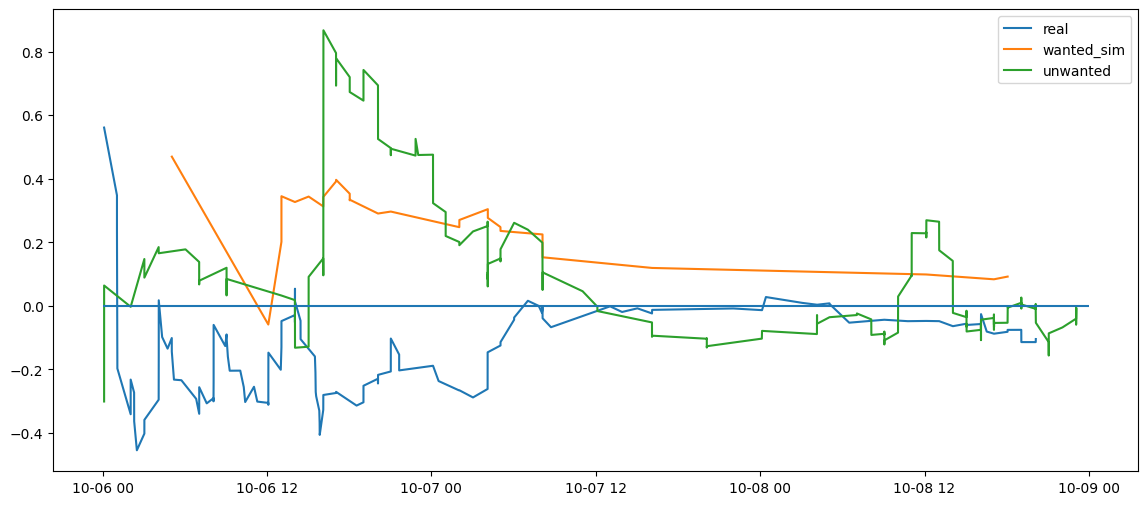

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(14, 6))
plt.plot(real_df.index, real_df.ema_16, label='real')
plt.plot(wanted_sim_df.index, wanted_sim_df.ema_16, label='wanted_sim')
plt.plot(unwanted_df.index, unwanted_df.ema_16, label='unwanted')
plt.hlines(y=0, xmin=start, xmax=start+timedelta(days=3))
plt.legend()
# plt.show()
# wanted_df.plot(figsize=(12, 12))